In [ ]:
#!pip install tensorflow==2.10.0
#!pip install torch==1.12.1
#!pip install transformers==4.20.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd

# Reading the csv file
df = pd.read_csv('/content/drive/MyDrive/RansomwareData.csv')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
X = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1).values
y = df[df.columns[2]]

y_binary = df[df.columns[1]].values

# Create group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

y_group = y.apply(convert_to_group).values
y_specific = df[df.columns[2]].values

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Lambda
from tensorflow.keras.models import Model, Sequential

# Define a simplified transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the simplified model
def create_simplified_model(input_shape):
    inputs = Input(shape=input_shape)
    dense_reduced = Dense(64, activation="relu")(inputs)
    dense_reduced = Lambda(lambda x: tf.expand_dims(x, axis=1))(dense_reduced)  # Add sequence dimension

    transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=64)
    x = transformer_block(dense_reduced)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # Pooling to reduce sequence dimension
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)

    # Classification heads
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
    specific_output = Dense(12, activation='softmax', name='specific_output')(x)

    model = Model(inputs=inputs, outputs=[binary_output, specific_output])
    return model

# Create and compile the model
model = create_simplified_model((30967,))
model.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'specific_output': 'sparse_categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'specific_output': 'accuracy'})

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 30967)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 64)             │      1,981,952 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 1, 64)          │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_7       │ (None, 1, 64)          │         74,944 │ lambda_7[0][0]         │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ transformer_block_7[0… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 64)             │              0 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ binary_output (Dense)     │ (None, 1)              │             65 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ specific_output (Dense)   │ (None, 12)             │            780 │ dropout_23[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,061,901 (7.87 MB)

 Trainable params: 2,061,901 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_binary, y_test_binary, y_train_group, y_test_group = train_test_split(X, y, y_binary, y_group, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train,
                    {'binary_output': y_train_binary, 'specific_output': y_train},
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - binary_output_accuracy: 0.7270 - loss: 2.2594 - specific_output_accuracy: 0.5111 - val_binary_output_accuracy: 0.9098 - val_loss: 1.1170 - val_specific_output_accuracy: 0.7418
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - binary_output_accuracy: 0.9643 - loss: 0.8921 - specific_output_accuracy: 0.7808 - val_binary_output_accuracy: 0.9672 - val_loss: 0.7282 - val_specific_output_accuracy: 0.8279
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - binary_output_accuracy: 0.9873 - loss: 0.5640 - specific_output_accuracy: 0.8524 - val_binary_output_accuracy: 0.9754 - val_loss: 0.6762 - val_specific_output_accuracy: 0.8361
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - binary_output_accuracy: 0.9870 - loss: 0.3899 - specific_output_accuracy: 0.9092 - val_binary_output_accuracy: 0.9754 - val_loss: 0.6801 - val_specific_output_accuracy: 0.8484
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - binary_output_accuracy: 0.9875 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions
predictions = model.predict(X_test)

# Binary predictions and metrics
binary_predictions = (predictions[0] > 0.5).astype(int)  # Convert probabilities to 0 or 1
binary_accuracy = accuracy_score(y_test_binary, binary_predictions)
binary_precision = precision_score(y_test_binary, binary_predictions)
binary_recall = recall_score(y_test_binary, binary_predictions)
binary_f1 = f1_score(y_test_binary, binary_predictions)
# Specific predictions and metrics
specific_predictions = np.argmax(predictions[1], axis=1)
specific_accuracy = accuracy_score(y_test, specific_predictions)
specific_precision = precision_score(y_test, specific_predictions, average='macro')
specific_recall = recall_score(y_test, specific_predictions, average='macro')
specific_f1 = f1_score(y_test, specific_predictions, average='macro')

# Print the results
print(f"Binary Classification Metrics:\n"
      f"Accuracy: {binary_accuracy:.4f}\n"
      f"Precision: {binary_precision:.4f}\n"
      f"Recall: {binary_recall:.4f}\n"
      f"F1 Score: {binary_f1:.4f}")

print(f"\nSpecific Classification Metrics:\n"
      f"Accuracy: {specific_accuracy:.4f}\n"
      f"Precision: {specific_precision:.4f}\n"
      f"Recall: {specific_recall:.4f}\n"
      f"F1 Score: {specific_f1:.4f}")


 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Binary Classification Metrics:
Accuracy: 0.9803
Precision: 0.9664
Recall: 0.9829
F1 Score: 0.9746

Specific Classification Metrics:
Accuracy: 0.8230
Precision: 0.5124
Recall: 0.4904
F1 Score: 0.4890


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


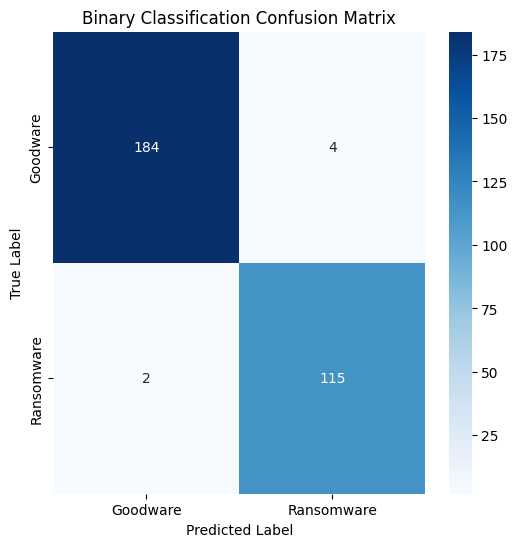

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


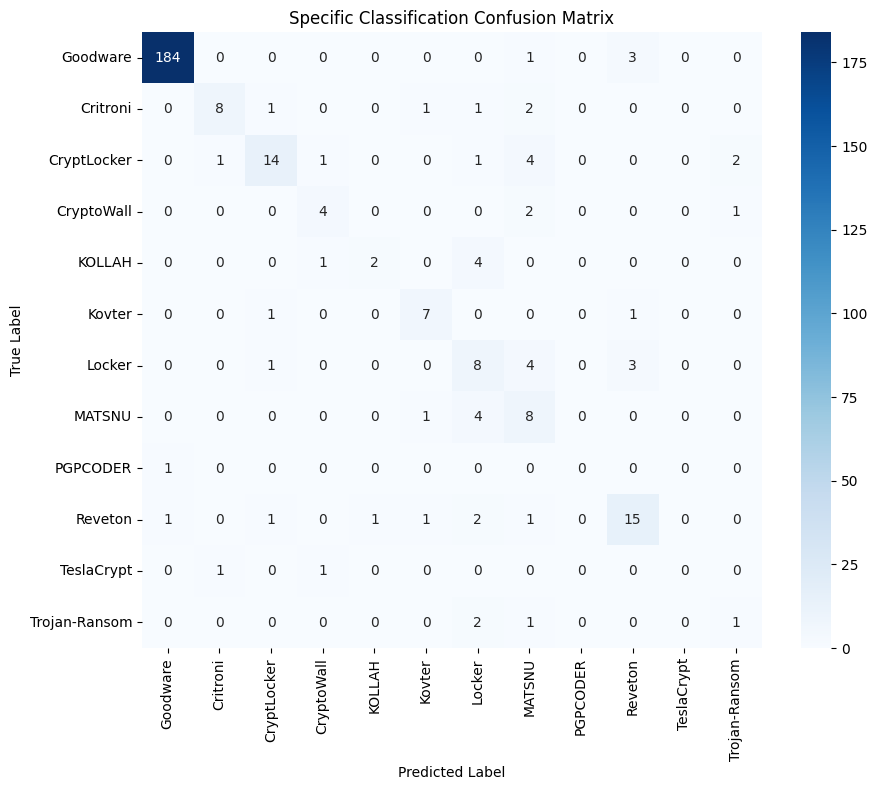

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Get predictions for binary classification head
y_binary_pred = model.predict(X_test)[0]
y_binary_pred_classes = (y_binary_pred > 0.5).astype("int32")


cm_binary = confusion_matrix(y_test_binary, y_binary_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues", xticklabels=['Goodware', 'Ransomware'], yticklabels=['Goodware', 'Ransomware'])
plt.title('Binary Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get predictions for specific classification head
y_specific_pred = model.predict(X_test)[1]
y_specific_pred_classes = y_specific_pred.argmax(axis=1)

# Compute confusion matrix
cm_specific = confusion_matrix(y_test, y_specific_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
specific_labels = ['Goodware', 'Critroni', 'CryptLocker', 'CryptoWall', 'KOLLAH', 'Kovter', 'Locker', 'MATSNU', 'PGPCODER', 'Reveton', 'TeslaCrypt', 'Trojan-Ransom']
sns.heatmap(cm_specific, annot=True, fmt="d", cmap="Blues", xticklabels=specific_labels, yticklabels=specific_labels)
plt.title('Specific Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


KeyError: 'binary_output_loss'

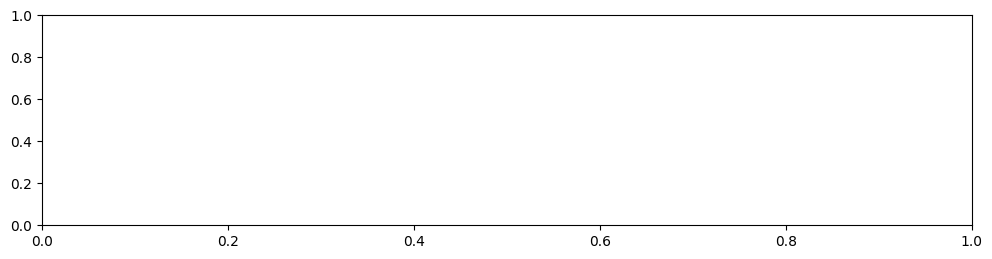

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['binary_output_loss'], linestyle='--', label='Binary Output Loss')
plt.plot(history.history['val_binary_output_loss'], label='Val Binary Output Loss')
plt.plot(history.history['specific_output_loss'], linestyle='--', label='Specific Output Loss')
plt.plot(history.history['val_specific_output_loss'], label='Val Specific Output Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 1, 2)
plt.plot(history.history['binary_output_accuracy'], linestyle='--', label='Binary Output Accuracy')
plt.plot(history.history['val_binary_output_accuracy'], label='Val Binary Output Accuracy')
plt.plot(history.history['specific_output_accuracy'], linestyle='--', label='Specific Output Accuracy')
plt.plot(history.history['val_specific_output_accuracy'], label='Val Specific Output Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()
